In [1]:
!pip3 install -U langgraph langsmith langchain_anthropic

  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached httpcore-1.0.7-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached httpcore-1.0.7-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.2 MB/s eta 0:00:00
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
Using cached h11-0.14.0-py3-none-any.whl (58 kB)


In [9]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [19]:
from typing import Annotated, Union
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    alt_text: str
    qa_questions: list
    function_details: dict
    generated_image: str
    evaluation: dict

llm = ChatAnthropic(model="claude-3-sonnet-20240620")

# Node functions
def process_alt_text(state: State):
    messages = [{"role": "user", "content": "Generate detailed alt text for an image based on the previous context"}]
    response = llm.invoke(messages)
    return {"alt_text": response.content}

def generate_qa(state: State):
    messages = [{"role": "user", "content": f"Based on this alt text: {state['alt_text']}, generate 3 specific QA questions to evaluate the quality of an image that would be generated"}]
    response = llm.invoke(messages)
    return {"qa_questions": response.content.split('\n')}

def generate_function(state: State):
    messages = [{"role": "user", "content": f"Based on this alt text: {state['alt_text']}, provide a function name and parameters that would generate such an image"}]
    response = llm.invoke(messages)
    return {"function_details": response.content}

def generate_image(state: State):
    # Placeholder for actual image generation
    # You would implement your image generation logic here
    return {"generated_image": "generated_image_data"}

def evaluate_image(state: State):
    messages = [{"role": "user", "content": f"""Evaluate this image against these QA questions:
    Questions: {state['qa_questions']}
    Image: {state['generated_image']}
    Provide pass/fail and detailed feedback."""}]
    response = llm.invoke(messages)
    return {"evaluation": {
        "feedback": response.content,
        "passed": "pass" in response.content.lower()
    }}

def reprocess_alt_text_and_image_with_feedback(state: State):
    messages = [{"role": "user", "content": f"""
    Previous attempt failed with this feedback: {state['evaluation']['feedback']}
    Previous alt text was: {state['alt_text']}
    
    Please generate an improved alt text that addresses the feedback issues.
    """}]
    response = llm.invoke(messages)
    return {"alt_text": response.content}

def should_retry(state: State):
    return state["evaluation"]["passed"]  # Changed to return passed directly instead of not passed

# Graph construction
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("process_alt_text", process_alt_text)
graph_builder.add_node("generate_qa", generate_qa)
graph_builder.add_node("generate_function", generate_function)
graph_builder.add_node("generate_image", generate_image)
graph_builder.add_node("evaluate_image", evaluate_image)
graph_builder.add_node("reprocess_alt_text_and_image_with_feedback", reprocess_alt_text_and_image_with_feedback)


# Add edges - corrected parallel processing
graph_builder.add_edge(START, "process_alt_text")
graph_builder.add_edge("process_alt_text", "generate_qa")
graph_builder.add_edge("process_alt_text", "generate_function")
graph_builder.add_edge("generate_qa", "generate_image")
graph_builder.add_edge("generate_function", "generate_image")
graph_builder.add_edge("generate_image", "evaluate_image")
graph_builder.add_conditional_edges(
    "evaluate_image",
    should_retry,
    {
        True: "END",  # If failed, retry with new function
        False: "reprocess_alt_text_and_image_with_feedback"  # If passed, end the process
    }
)

# Add edges from reprocessing back to the main flow
graph_builder.add_edge("reprocess_alt_text_and_image_with_feedback", "generate_function")


# Compile the graph
graph = graph_builder.compile()

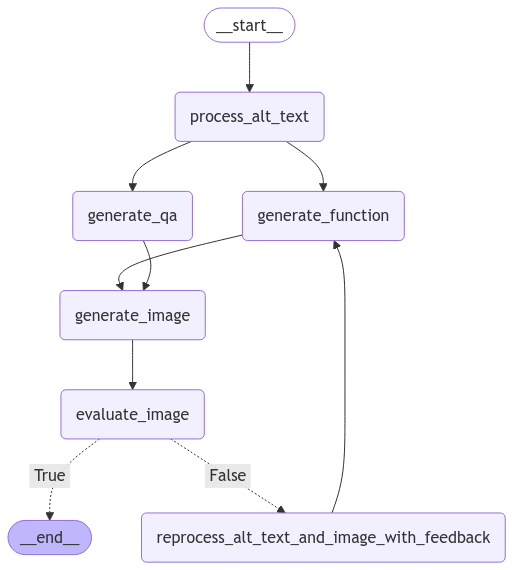

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass